In [1]:
import pickle
import numpy as np
import pandas as pd
import multiprocessing
import my_functions as my
import matplotlib.pyplot as plt

from tqdm.auto import tqdm, trange

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [2]:
# Importing the data
data = np.loadtxt('zipcombo.dat')

y = data[:, 0]
X = data[:, 1:]

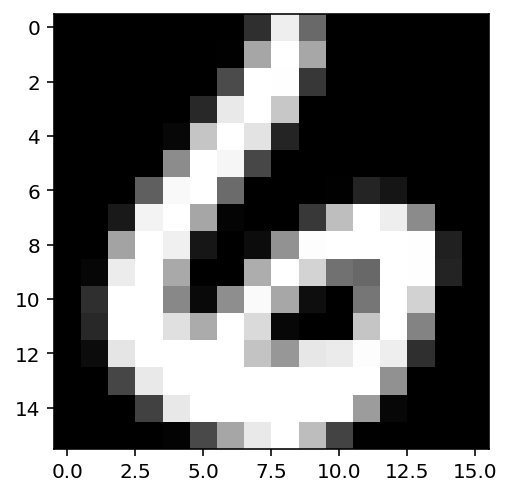

In [3]:
plt.imshow(X[0].reshape(16,16), cmap = 'gray');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


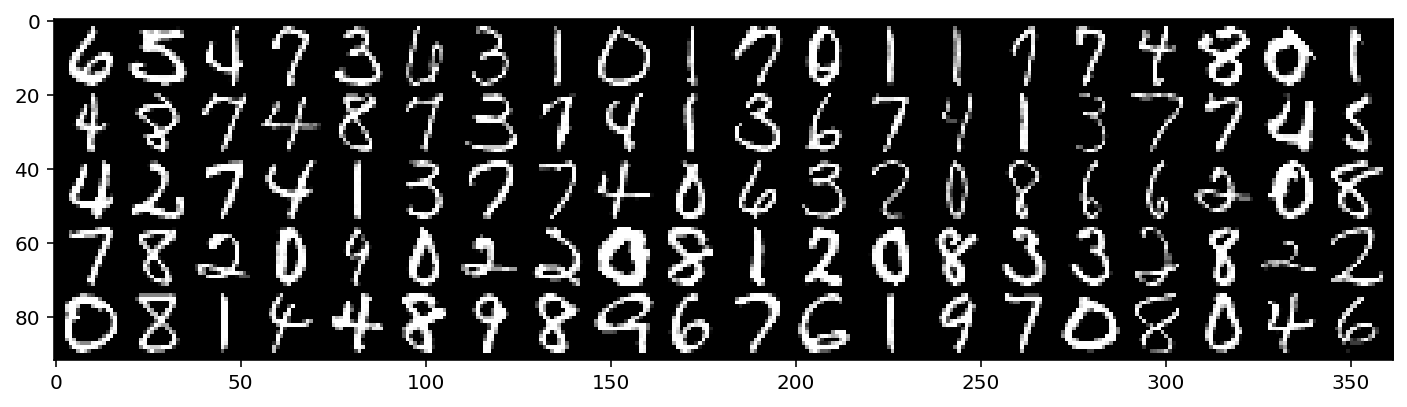

In [4]:
# Visualising a sample of the data
# Importing torch utilities just for plotting
import torch

from torchvision.utils import make_grid

plotting = torch.Tensor(X.reshape(-1,1,16,16))
plt.figure(figsize = (12,4))
plt.imshow(make_grid(plotting[:100], nrow = 20).permute(1,2,0));

In [5]:
def gaussian_kernel_matrix(X1, X2, gamma):
    """Fast computation of the Gaussian kernel matrix for a given dataset.
    """
    
    # Take the squared norms of each row
    squared_norm1 = np.sum(X1** 2, axis = 1)
    squared_norm2 = np.sum(X2 ** 2, axis = 1)
    
    # Exploiting the identity: ||x-y||^2 = ||x||^2 + ||y||^2 - 2 * x^T * y  and numpy broadcasting
    K = np.exp(-gamma * (squared_norm1[:, None] + squared_norm2[None, :] - 2 * X1 @ X2.T))
    
    return K

In [6]:
X_train, X_test, y_train, y_test = my.train_test_split(X, y, test_size = 0.2, random_state = 2020)

In [7]:
def signed_one_hot(y, classes = 10):
    """Produces a one_hot encoding of the given vector of labels.
    
    Args:
    y (ndarray): vector of labels to encode
    classes (int): number of classes to encode represented in y. Default is 10 for our case.
    
    Returns:
    Y_one_hot (ndarray): matrix of shape (len(y), classes) of one hot encoded y
    """
    
    # Initialise matrix of negative ones
    Y_one_hot = - np.ones((len(y), classes))
    
    # Fancy indexing to get "one hot". Assigning 1 to element at position y in every row
    Y_one_hot[range(y.shape[0]), (y.astype(int))] = 1
    
    return Y_one_hot


In [8]:
def train_test_perceptron(X_train, y_train, X_test, Y_test, epochs = 5):
    """Main training routine for the one vs all multi-class kernel perceptron.
    Epochs are run in tiling mode."""
    
    # Matrix of alpha which each row represent each of the 10 classes, change column value after each iteration   
    y_train = np.tile(y_train.T, epochs).T
    
    A = np.tile(X_train.T,epochs).T
    X_train =np.tile(A, epochs)
    X_test =np.tile(X_test.T, epochs).T
    
    alpha = np.zeros((10,len(X_train))) #  Initialise alphas to zeros

    train_mistakes = 0
    for t in range(len(X_train)):

        WX = alpha[:,:t] @ X_train[:t,t].reshape(-1,1) # this is the summation term 
        
        # print(f'{y_train[t,:]=}')
        # print(f'{np.squeeze(WX)=}')

        for i in range(10):
            if y_train[t,i] * np.squeeze(WX)[i] <= 0:
                alpha[:,t][i] -=  my.sign(np.squeeze(WX)[i])

    train_mistakes = 0
    WX_train = (alpha @ X_train).T
    Y_pred_train = - np.ones_like(WX_train)
    Y_pred_train[range(y_train.shape[0]), np.argmax(WX_train, axis = 1)] = 1 
    train_mistakes = (Y_pred_train != y_train).sum() / 2
    # Batch predict all of the test data to get test accuracy
    
    test_mistakes = 0
    WX_test = (alpha @ X_test).T
    Y_pred_test = - np.ones_like(WX_test)
    Y_pred_test[range(Y_test.shape[0]), np.argmax(WX_test, axis = 1)] = 1 

    test_mistakes = (Y_pred_test != Y_test).sum() / 2  # By comparing them like this when there is a mistake we count it two times
    train_accuracy = (X_train.shape[1] - train_mistakes)/(X_train.shape[1])
    test_accuracy = ((X_test.shape[1]) - test_mistakes)/((X_test.shape[1]))
    
    return train_accuracy, test_accuracy, alpha

# Finding an interval of gammas
Here we perform a simple binary search to find a suitable interval to cross-validate gamma over.

In [9]:
def binary_search_gamma(upper_value, lower_value, epochs = 3, steps = 10, interval = 6):
    
    
    upper_value = upper_value
    lower_value = lower_value
    

    for step in trange(steps):
        gamma_choice = []
        train_choice = []
        test_choice = []
        for gamma in np.arange (lower_value, upper_value, ((upper_value - lower_value) / interval)):
            K_train, K_test = gaussian_kernel_matrix(X_train, X_train, gamma), gaussian_kernel_matrix(X_train, X_test, gamma)  
            train_accuracy, test_accuracy, alpha = train_test_perceptron_tile(K_train, y_train_hot, K_test, y_test_hot, epochs)
            gamma_choice.append(gamma)
            train_choice.append(train_accuracy)
            test_choice.append(test_accuracy)
        if test_choice[-1] > test_choice[0]:
            upper_value = gamma_choice[-1]
            lower_value = gamma_choice[0] / 2
        elif test_choice[0] >= test_choice[-1]:
            upper_value = gamma_choice[-1]/2
            lower_value = gamma_choice[0]
    np.array(gamma_choice)
    np.array(train_choice)
    np.array(test_choice) 
    choice = np.stack((gamma_choice, train_choice, test_choice), axis = 1)
    return choice
binary_search_gamma(0, 2, epochs = 3, steps = 10)

After one run of binary search between 0 and 2, 10 steps:

0.03125 to 0.04780372, step of 0.00325


It takes around 11 minutes to run the full Kernel perceptron with augmented data for 5 epochs (train: 1. test: .97)

It takes only 24s to run the "simplified" version over 50 epochs (train: .994, test: .965)

# Protocol 1 - Multiple train/test runs

In [10]:
# Comment on how many epochs you chose to use
def multi_run_gaussian(data, epochs = 10, gammas = None, runs = 20):
    """Runs the kernel perceptron multiple times with different values of gamma and train-test splits"""
    # Split labels from samples
    y = data[:, 0]
    X = data[:, 1:]
    
    # Initialise polynomial degrees if not given
    if gammas is None:
        gammas = [0.03125, 0.0345, 0.03775, 0.041, 0.04425,  0.0475, 0.05075]
    
    train_losses = np.zeros((len(gammas), runs))
    test_losses = np.zeros((len(gammas), runs))
    
    for run in tqdm(range(runs)):
        
        # Randomply split train and test data at each run
        X_train, X_test, y_train, y_test = my.train_test_split(X, y, test_size = 0.2, random_state = np.random.randint(100))
        y_train_hot = signed_one_hot(y_train)
        y_test_hot = signed_one_hot(y_test)
        
        for i, gamma in enumerate(gammas):
            K_train, K_test = gaussian_kernel_matrix(X_train, X_train, gamma), gaussian_kernel_matrix(X_train, X_test, gamma)
            train_accuracy, test_accuracy, _ = train_test_perceptron(K_train, y_train_hot, K_test, y_test_hot, epochs)
            train_losses[i, run] = train_accuracy
            test_losses[i, run] = test_accuracy
    return train_losses, test_losses

In [11]:
train_losses, test_losses = multi_run_gaussian(data, epochs = 4)
my.save_obj(train_losses, 'train_losses_gauss_20')
my.save_obj(test_losses, 'test_losses_gauss_20')

100%|██████████| 20/20 [1:28:32<00:00, 265.62s/it]


# Protocol 2 - Cross validation

In [12]:
def cross_validate_gaussian(data, n_splits = 5, cross_epochs = 10,  epochs = 10, gammas = None, runs = 20):
    
    # Initialise polynomial degrees if not given
    if gammas is None:
        gammas = [0.03125, 0.0345, 0.03775, 0.041, 0.04425,  0.0475, 0.05075]
    
    # Split labels from samples
    y = data[:, 0]
    X = data[:, 1:]
    
    train_losses = np.zeros((len(gammas), runs, n_splits))
    val_losses = np.zeros((len(gammas), runs, n_splits))
    best_gammas = np.zeros((runs))
    test_accuracies = np.zeros((runs))
    
    for run in tqdm(range(runs), desc = 'Runs'):
            
        # Randomply split train and test data
        X_train, X_test, y_train, y_test = my.train_test_split(X, y, test_size = 0.2, random_state = np.random.randint(100))
        
        y_train = y_train[:, None]
        y_test = y_test[:, None]
        
        for i_split, (train_indices, val_indices) in enumerate(my.cross_validation_split(X_train, n_splits)):

            # Split the training data into cross-validation training and validation sets
            X_cv_train = X_train[train_indices,:]
            y_cv_train = y_train[train_indices,:]
            X_cv_val = X_train[val_indices,:]
            y_cv_val = y_train[val_indices,:]
            # Prepare data to run: one-hot the ys
            y_cv_train_hot = signed_one_hot(np.squeeze(y_cv_train))     # Need to squeeze for compatibility with one-hot validation function
            y_cv_val_hot = signed_one_hot(np.squeeze(y_cv_val))
            for i, gamma in enumerate(gammas):
                K_cv_train, K_cv_val = gaussian_kernel_matrix(X_cv_train, X_cv_train, gamma), gaussian_kernel_matrix(X_cv_train, X_cv_val, gamma)
                train_accuracy, validation_accuracy, _ = train_test_perceptron(K_cv_train, y_cv_train_hot, K_cv_val, y_cv_val_hot, cross_epochs)
                train_losses[i, run, i_split] = train_accuracy
                val_losses[i, run, i_split] = validation_accuracy
                
        # Extract and save current best degree
        best_gamma = gammas[np.argmax(np.mean(val_losses[:, run, :], axis = 1))]
        best_gammas[run] = best_gamma
        
        
        # Retrain on the test set using best degree
        y_train_hot = signed_one_hot(np.squeeze(y_train))  # Need to squeeze to counter dimension augmentation: compatibility with one hot function
        y_test_hot = signed_one_hot(np.squeeze(y_test))
        K_train, K_test = gaussian_kernel_matrix(X_train, X_train, best_gamma), gaussian_kernel_matrix(X_train, X_test, best_gamma)
        
        
        _, test_accuracy, _ = train_test_perceptron(K_train, y_train_hot, K_test, y_test_hot, epochs)
        test_accuracies[run] = test_accuracy
        
    return train_losses, val_losses, best_gammas, test_accuracies
        
train_losses, val_losses, best_gammas, test_accuracies = cross_validate_gaussian(data, n_splits = 5, cross_epochs = 4,  epochs = 4, gammas = None, runs = 20)

np.save('train_losses_cross_gauss', train_losses)
np.save('val_losses_cross_gauss', val_losses)
np.save('best_gammas_gauss', best_gammas)
np.save('test_accuracies_cross_gauss', test_accuracies)

Runs: 100%|██████████| 20/20 [3:23:22<00:00, 610.15s/it]  
